# Feed Forward Neural Networks - Binary classification problem
## by Vesna Pop-Dimitrijoska
---

### FFNN using SMOTE + Random UnderSample for Imbalanced Classification version 3
---

Dataset:     
1. `heart-data.csv`      

Task:
1. EDA (single и bivariate)     
2. NAN values imputation     
3. Binary classification with Feed Forward Neural Networks for predicting target class 'stroke'

---
# Loading the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import copy
import os
import pathlib
from collections import Counter

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping, ModelCheckpoint

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# Read the Dataset

In [3]:
org_df = pd.read_csv('/content/heart-data.csv', index_col=0).reset_index(drop=True)
df = org_df.copy()

display(df.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


---
## Encoding Categorical features

In [4]:
cat_cols = list(df.select_dtypes('object').columns)

for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].values)

---
## Imputing NaN values with Linear Regression

In [5]:
TARGET_COL='stroke'

In [6]:
df_copy = df.copy()

# Removing 'stroke' column, because this is future target
df_copy = df_copy.drop([TARGET_COL], axis=1)

# Spliting the data into two sets: one with NaN 'bmi' values and one without NaN 'bmi' values
train_data = df_copy[df_copy['bmi'].notnull()]
test_data = df_copy[df_copy['bmi'].isnull()]

x_train = train_data.drop(['bmi'], axis=1)
y_train = train_data['bmi']
x_test = test_data.drop(['bmi'], axis=1)

model = LinearRegression()
model.fit(x_train, y_train)

predicted_bmi = model.predict(x_test)

# Filling NaN values in 'bmi' column with the predicted values
df_copy.loc[df_copy['bmi'].isnull(), 'bmi'] = predicted_bmi

# Add 'stroke' column back to the DataFrame
df['bmi'] = df_copy['bmi']

---
# Feed Forward Neural Network - Binary classification model

In [7]:
X = df.drop(columns=[TARGET_COL])
Y = df[TARGET_COL]

## SMOTE for Imbalanced Classification

In [8]:
print('Shape before SMOTE oversampling', Y.shape)

Shape before SMOTE oversampling (5110,)


In [10]:
# SMOTE + Random UnderSample

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, Y = pipeline.fit_resample(X, Y)

In [11]:
print('Shape after SMOTE oversampling', Y.shape)

Shape after SMOTE oversampling (1093,)


## Train – Validation – Test  stratified splits and scaling

In [12]:
def split_and_scale(df: pd.DataFrame):

    X_train, X_vt, Y_train, Y_vt = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=SEED, stratify = Y)

    assert X_train.shape[0] == Y_train.shape[0]
    assert X_vt.shape[0]    == Y_vt.shape[0]
    assert X_train.shape[1] == X_vt.shape[1]


    X_val, X_test, Y_val, Y_test = train_test_split(X_vt, Y_vt, test_size=0.5, shuffle=True, random_state=SEED, stratify = Y_vt)

    assert X_val.shape[0]   == Y_val.shape[0]
    assert X_test.shape[0]  == Y_test.shape[0]
    assert X_val.shape[1]   == X_test.shape[1]


    X_train = MinMaxScaler().fit_transform(X_train)
    X_val   = MinMaxScaler().fit_transform(X_val)
    X_test  = MinMaxScaler().fit_transform(X_test)

    return X_train, Y_train.to_numpy(), X_val, Y_val.to_numpy(), X_test, Y_test.to_numpy()

## Model definition and optimization process

In [13]:
def make_and_compile_model(hyper_params: dict, show_summary: bool = False) -> Sequential:

    model = Sequential()

    # INPUT LAYER
    model.add(Input(hyper_params['input_size']))

    # HIDDEN LAYERS
    for hu, ac, dp, bn, kr in zip(  hyper_params['h_layers'],
                                    hyper_params['activations'],
                                    hyper_params['dropout_size'],
                                    hyper_params['batch_normalization'],
                                    hyper_params['kernel_regularizers'],
                                    ):
        if kr is None:
            model.add(Dense(hu, activation=ac))
        else:
            model.add(Dense(hu, activation=ac, kernel_regularizer=kr))
        if bn:
            model.add(BatchNormalization())
        if dp > 0.0:
            model.add(Dropout(dp))

    # OUTPUT LAYER
    model.add(Dense(hyper_params['output_size'], activation=hyper_params['output_activation']))

    if show_summary:
        model.summary()

    model.compile(loss=hyper_params['loss'], optimizer=hyper_params['optimizer'], metrics=hyper_params['metrics'])

    return model

## Training the model

In [14]:
def train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=False):

    es_cbk = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    #chp_cbk = ModelCheckpoint(monitor='val_loss', filepath=os.path.join('models', model_name), save_best_only=True)

    model_history = model.fit(X_train,
                            Y_train,
                            epochs=1000,
                            batch_size = 128, # 16, 32, 64, 128, 256,
                            validation_data = (X_val, Y_val),
                            callbacks = [es_cbk],  #, chp_cbk],
                            shuffle=True,
                            verbose=0 if quiet else 1
                            )
    return model_history

In [15]:
def learning_curve(model_history, model_name):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.plot(title=f'Loss learning curve ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

## Model prediction and model evaluation


In [16]:
def test_eval_model(model, model_name, X_test, Y_test) -> dict:

    Y_pred_probability = model.predict(X_test, verbose=0)

    Threshold = 0.5   # OPTION 1
#   Threshold = 0.4   # OPTION 2
#   Threshold = 0.3   # OPTION 3
#   Threshold = 0.2   # OPTION 4

    Y_pred = (Y_pred_probability >= Threshold).astype(int)

    eval_dict = {
      'Model name:': model_name,
      'F1 score (macro)  (%):': round((f1_score(Y_test, Y_pred, average='macro'))*100, 3),
      'F1 score (binary) (%):': round((f1_score(Y_test, Y_pred, average='binary'))*100, 3),
      'Accuracy          (%):': round((accuracy_score(Y_test, Y_pred))*100, 3),
      'Precision score   (%):': round((precision_score(Y_test, Y_pred))*100, 3),
      'Recall score      (%):': round((recall_score(Y_test, Y_pred))*100, 3),
      'Confusion Matrix     :': confusion_matrix(Y_test, Y_pred)
      }

    display(pd.DataFrame.from_dict(eval_dict, orient='index'))

    ClassificationReport = pd.DataFrame(classification_report(Y_test, Y_pred, output_dict=True)).transpose()
    ClassificationReport.index.name = 'Classification Report'
    display(ClassificationReport)

    return eval_dict

In [17]:
def model_loop(hyper_params: dict, df: pd.DataFrame, model_name: str):
    print("1. Getting and splitting data...", end=' ')
    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_and_scale(df)
    print("Done!")

    print("2. Creating and compiling model...", end=' ')
    model = make_and_compile_model(hyper_params, show_summary=False)
    print("Done!")

    print("3. Training model...", end=' ')
    model_history = train_model(model, model_name, X_train, Y_train, X_val, Y_val, quiet=True)
    print("Done!")

    print("4. Validating and evaluating model...", end=' ')
    learning_curve(model_history, model_name)
    metrics_dict = test_eval_model(model, model_name, X_test, Y_test)
    print("Done!")
    print("---------------------------------------------------------------------------------------\n\n")
    return metrics_dict


Model name:  Baseline_model
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

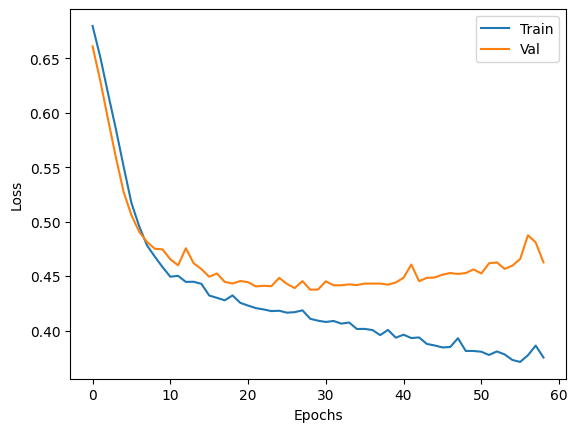

,0
Model name:,Baseline_model
F1 score (macro) (%):,82.483
F1 score (binary) (%):,80.412
Accuracy (%):,82.727
Precision score (%):,81.25
Recall score (%):,79.592
Confusion Matrix :,"[[52, 9], [10, 39]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.838710,0.852459,0.845528,61.000000
1,0.812500,0.795918,0.804124,49.000000
accuracy,0.827273,0.827273,0.827273,0.827273
macro avg,0.825605,0.824189,0.824826,110.000000
weighted avg,0.827034,0.827273,0.827085,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp1_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

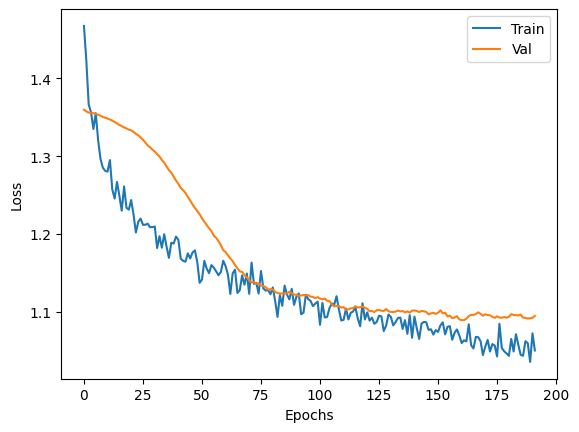

,0
Model name:,Exp1_5Layers
F1 score (macro) (%):,79.759
F1 score (binary) (%):,77.551
Accuracy (%):,80.0
Precision score (%):,77.551
Recall score (%):,77.551
Confusion Matrix :,"[[50, 11], [11, 38]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.819672,0.819672,0.819672,61.0
1,0.775510,0.775510,0.775510,49.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.797591,0.797591,0.797591,110.0
weighted avg,0.800000,0.800000,0.800000,110.0


Done!
---------------------------------------------------------------------------------------



Model name:  Exp2_5Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

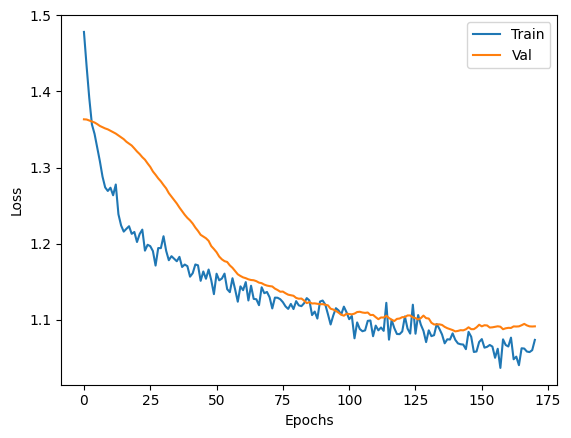

,0
Model name:,Exp2_5Layers
F1 score (macro) (%):,78.0
F1 score (binary) (%):,76.0
Accuracy (%):,78.182
Precision score (%):,74.51
Recall score (%):,77.551
Confusion Matrix :,"[[48, 13], [11, 38]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.813559,0.786885,0.800000,61.000000
1,0.745098,0.775510,0.760000,49.000000
accuracy,0.781818,0.781818,0.781818,0.781818
macro avg,0.779329,0.781198,0.780000,110.000000
weighted avg,0.783063,0.781818,0.782182,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp3_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

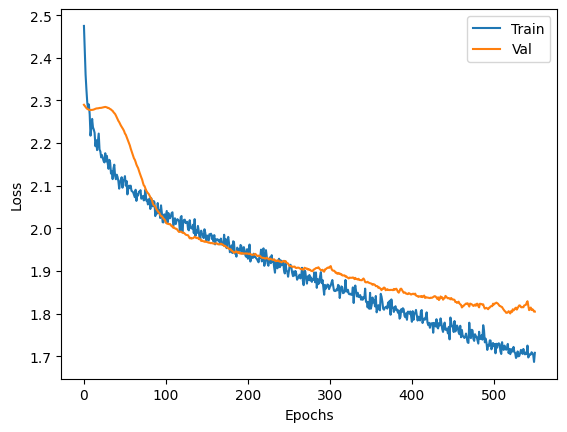

,0
Model name:,Exp3_6Layers
F1 score (macro) (%):,77.71
F1 score (binary) (%):,74.468
Accuracy (%):,78.182
Precision score (%):,77.778
Recall score (%):,71.429
Confusion Matrix :,"[[51, 10], [14, 35]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.784615,0.836066,0.809524,61.000000
1,0.777778,0.714286,0.744681,49.000000
accuracy,0.781818,0.781818,0.781818,0.781818
macro avg,0.781197,0.775176,0.777102,110.000000
weighted avg,0.781570,0.781818,0.780639,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp4_6Layers
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

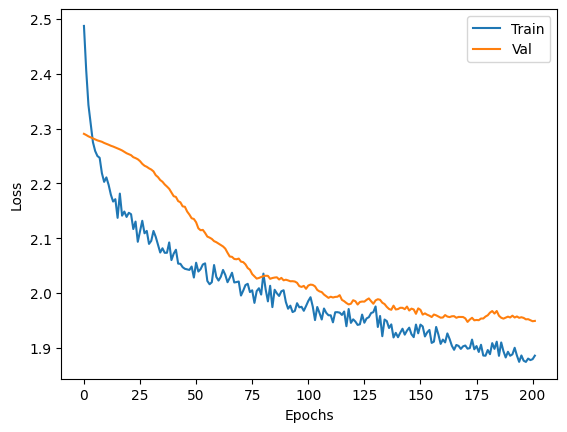

,0
Model name:,Exp4_6Layers
F1 score (macro) (%):,78.88
F1 score (binary) (%):,76.768
Accuracy (%):,79.091
Precision score (%):,76.0
Recall score (%):,77.551
Confusion Matrix :,"[[49, 12], [11, 38]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.816667,0.803279,0.809917,61.000000
1,0.760000,0.775510,0.767677,49.000000
accuracy,0.790909,0.790909,0.790909,0.790909
macro avg,0.788333,0.789394,0.788797,110.000000
weighted avg,0.791424,0.790909,0.791101,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp5_NO_bn
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

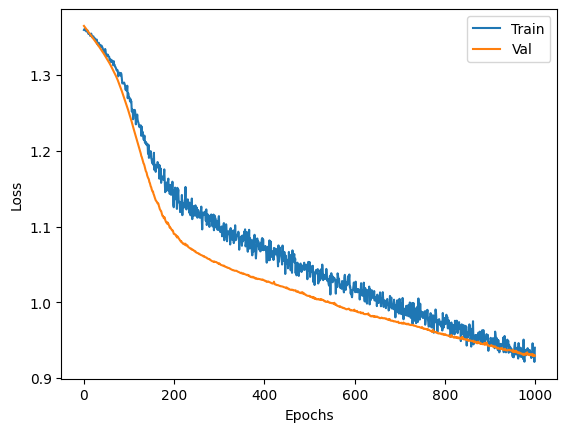

,0
Model name:,Exp5_NO_bn
F1 score (macro) (%):,78.88
F1 score (binary) (%):,76.768
Accuracy (%):,79.091
Precision score (%):,76.0
Recall score (%):,77.551
Confusion Matrix :,"[[49, 12], [11, 38]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.816667,0.803279,0.809917,61.000000
1,0.760000,0.775510,0.767677,49.000000
accuracy,0.790909,0.790909,0.790909,0.790909
macro avg,0.788333,0.789394,0.788797,110.000000
weighted avg,0.791424,0.790909,0.791101,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp6_NO_dp
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

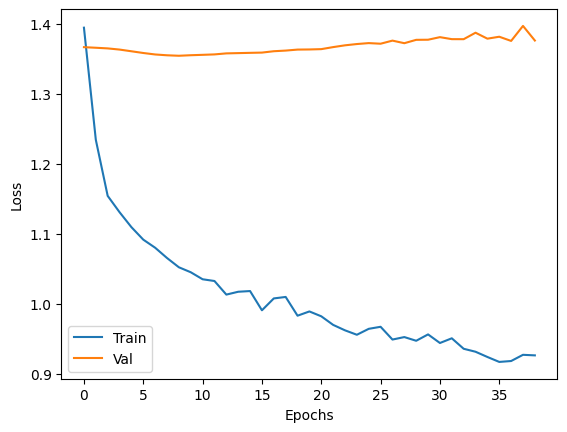

,0
Model name:,Exp6_NO_dp
F1 score (macro) (%):,49.051
F1 score (binary) (%):,33.766
Accuracy (%):,53.636
Precision score (%):,46.429
Recall score (%):,26.531
Confusion Matrix :,"[[46, 15], [36, 13]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.560976,0.754098,0.643357,61.000000
1,0.464286,0.265306,0.337662,49.000000
accuracy,0.536364,0.536364,0.536364,0.536364
macro avg,0.512631,0.509702,0.490509,110.000000
weighted avg,0.517905,0.536364,0.507184,110.000000


Done!
---------------------------------------------------------------------------------------



Model name:  Exp7_NO_kr
----------------------------------------
1. Getting and splitting data... Done!
2. Creating and compiling model... Done!
3. Training model... Done!
4. Validating and evaluating model... 

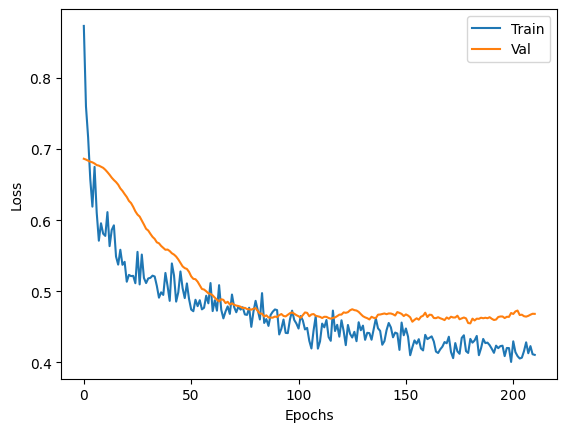

,0
Model name:,Exp7_NO_kr
F1 score (macro) (%):,77.823
F1 score (binary) (%):,75.0
Accuracy (%):,78.182
Precision score (%):,76.596
Recall score (%):,73.469
Confusion Matrix :,"[[50, 11], [13, 36]]"


,precision,recall,f1-score,support
Classification Report,,,,
0,0.793651,0.819672,0.806452,61.000000
1,0.765957,0.734694,0.750000,49.000000
accuracy,0.781818,0.781818,0.781818,0.781818
macro avg,0.779804,0.777183,0.778226,110.000000
weighted avg,0.781315,0.781818,0.781305,110.000000


Done!
---------------------------------------------------------------------------------------




In [18]:
grid_dict = {
    'Baseline_model': {
        'input_size': X.shape[1],

        'h_layers': [256, 64, 16],
        'activations': ['relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0],
        'batch_normalization': [False, False, False],
        'kernel_regularizers': [None, None] * 3,

        'output_size': 1,
        'output_activation': 'sigmoid',


        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp1_5Layers': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp2_5Layers': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp3_6Layers': {
        'input_size': X.shape[1],

        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.25, 0.2, 0.3, 0.25, 0.2, 0.3],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp4_6Layers': {
        'input_size': X.shape[1],

        'h_layers': [512, 256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.1, 0.15, 0.2, 0.1],
        'batch_normalization': [True, True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 6,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


     'Exp5_NO_bn': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.2, 0.15, 0.2, 0.15],
        'batch_normalization': [False, False, False, False, False],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


    'Exp6_NO_dp': {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0, 0, 0, 0, 0],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [L1L2(l1=1e-4, l2=1e-3)] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    },


    'Exp7_NO_kr':  {
        'input_size': X.shape[1],

        'h_layers': [256, 128, 64, 32, 16],
        'activations': ['relu', 'relu', 'relu', 'relu', 'relu'],
        'dropout_size': [0.15, 0.20, 0.15, 0.20, 0.15],
        'batch_normalization': [True, True, True, True, True],
        'kernel_regularizers': [None, None] * 5,

        'output_size': 1,
        'output_activation': 'sigmoid',

        'optimizer': 'SGD',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }
}

eval_results = []
for model_name, hyper_d in grid_dict.items():
    print('\nModel name: ', model_name)
    print('----------------------------------------')
    eval_results.append(model_loop(hyper_d, df, model_name))

# RESULTS

In [19]:
pd.DataFrame(eval_results)

,Model name:,F1 score (macro) (%):,F1 score (binary) (%):,Accuracy (%):,Precision score (%):,Recall score (%):,Confusion Matrix :
0,Baseline_model,82.483,80.412,82.727,81.250,79.592,"[[52, 9], [10, 39]]"
1,Exp1_5Layers,79.759,77.551,80.000,77.551,77.551,"[[50, 11], [11, 38]]"
2,Exp2_5Layers,78.000,76.000,78.182,74.510,77.551,"[[48, 13], [11, 38]]"
3,Exp3_6Layers,77.710,74.468,78.182,77.778,71.429,"[[51, 10], [14, 35]]"
4,Exp4_6Layers,78.880,76.768,79.091,76.000,77.551,"[[49, 12], [11, 38]]"
5,Exp5_NO_bn,78.880,76.768,79.091,76.000,77.551,"[[49, 12], [11, 38]]"
6,Exp6_NO_dp,49.051,33.766,53.636,46.429,26.531,"[[46, 15], [36, 13]]"
7,Exp7_NO_kr,77.823,75.000,78.182,76.596,73.469,"[[50, 11], [13, 36]]"


#### CONCLUSION:     
Significant improvment was made using SMOTE + Random UnderSample for balancing the class distribution in a dataset. However Random UnderSampler may lead to a loss of information, especially if it discards important samples from the majority class.

---